In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

# from matplotlib.colors import to_rgb, to_rgba

# def scatter(x, y, color, alpha_arr, **kwarg):
#     r, g, b = to_rgb(color)
#     # r, g, b, _ = to_rgba(color)
#     color = [(r, g, b, alpha) for alpha in alpha_arr]
#     plt.scatter(x, y, c=color, **kwarg)

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
import torchvision as tv
import torchvision.transforms as tr
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from core import networks
from core import toy_data
from core import models

In [26]:
def logit(x, alpha=1e-6):
    x = x * (1 - 2 * alpha) + alpha
    return torch.log(x) - torch.log(1 - x)

def logit_inv(x, alpha=1e-6):
    x = torch.exp(x)/(1+torch.exp(x))
    x = (x - alpha)/(1 - 2 * alpha)
    return x

def get_data(use_logit, data_name, batch_size):
    if use_logit:
        transform = tr.Compose([tr.ToTensor(), lambda x: x * (255. / 256.) + (torch.rand_like(x) / 256.), logit])
    else:
        transform = tr.Compose([tr.ToTensor(), lambda x: x * (255. / 256.) + (torch.rand_like(x) / 256.)])
    if data_name == "mnist":
        dset_train = tv.datasets.MNIST(root="../data", train=True, transform=transform, download=False)
        dset_test = tv.datasets.MNIST(root="../data", train=False, transform=transform, download=False)
    elif data_name == "fashionmnist":
        dset_train = tv.datasets.FashionMNIST(root="../data", train=True, transform=transform, download=False)
        dset_test = tv.datasets.FashionMNIST(root="../data", train=False, transform=transform, download=False)
    else:
        assert False, "wrong dataset"

    dload_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    dload_test = DataLoader(dset_test, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    return dload_train, dload_test
    
def plot_training_process(method_name, data_name):
    log = pd.read_csv('../logs/%s_%s.csv' % (method_name, data_name))

    fs = 15
    figsize(16,5)
    plt.subplot(121)
    plt.plot(log['loss'])
    plt.ylabel('loss', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    plt.subplot(122)
    plt.plot(np.abs(log['mmd']))
    plt.ylabel('MMD', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.yscale('log')
    plt.grid()
    
def plot_samples(method_name, data_name):
    data_shape = (28, 28)
    particles = torch.load('../checkpoints/particles_%s_%s' % (method_name, data_name), map_location=device)
    particles = particles.detach()
#     particles = particles[torch.randperm(len(particles))]
    particles = logit_inv(particles)
#     dload_train, dload_test = get_data(False, data_name, 30)
#     for train_samples, _ in dload_train:
#         train_samples = train_samples.view(-1, *data_shape).numpy()
#         break
    
    figsize(16,5)
    for i in range(3):
        for j in range(10):
            plt.subplot(3,10,j+i*10+1)
            plt.imshow(particles[j+i*10].view(data_shape).cpu().numpy(), 
                       cmap='gray', interpolation='nearest')
            plt.axis('off')
    plt.tight_layout()
    plt.show()
            
#     for i in range(10):
#         for j in range(3):
#             plt.subplot(3,10,i+j*10+1)
#             plt.imshow(train_samples[i+j*10], 
#                        cmap='gray', interpolation='nearest')
#             plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [5]:
device = torch.device('cpu')

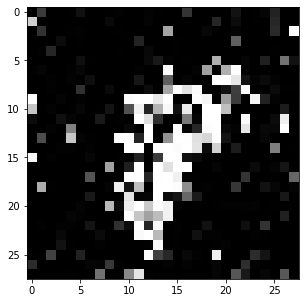

In [450]:
samples = torch.load('../checkpoints/samples_9999_eval__baseline_DM_mnist', map_location=device)
samples = logit_inv(samples).detach().numpy()
plt.imshow(samples[5,0], cmap='gray')

## Baseline

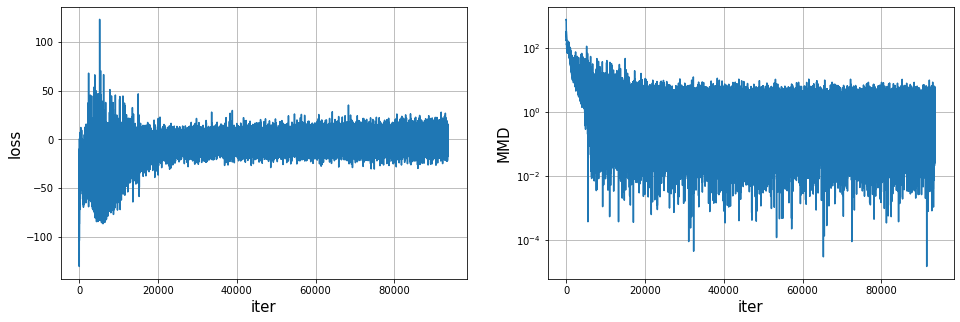

In [6]:
plot_training_process('baseline', 'mnist')

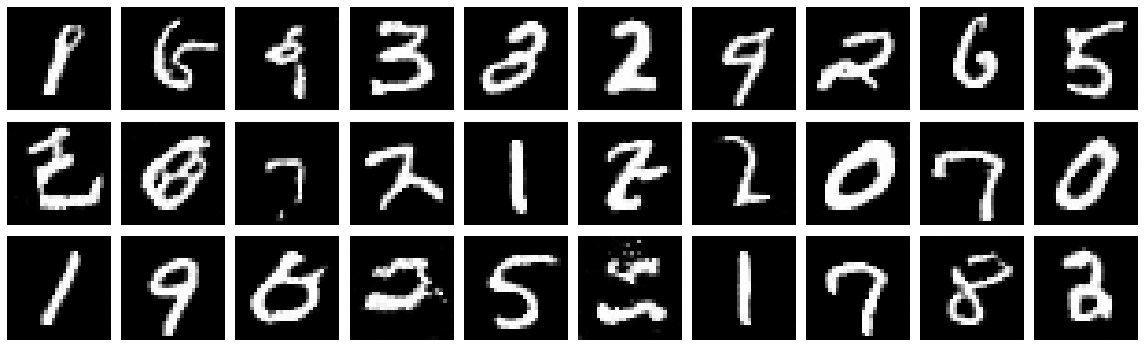

In [27]:
plot_samples('baseline', 'mnist')

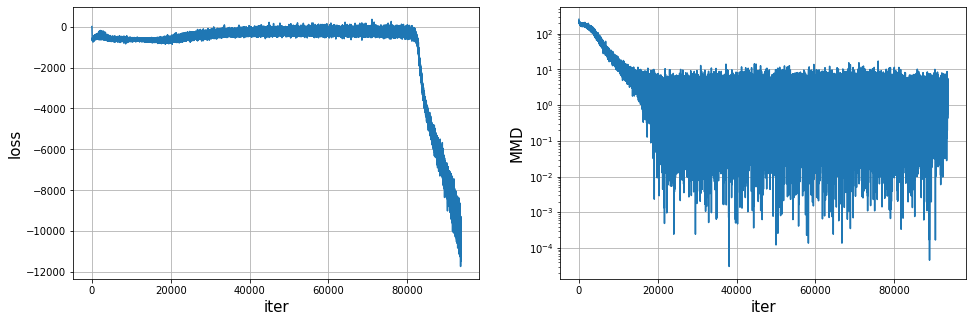

In [8]:
plot_training_process('baseline_right', 'mnist')

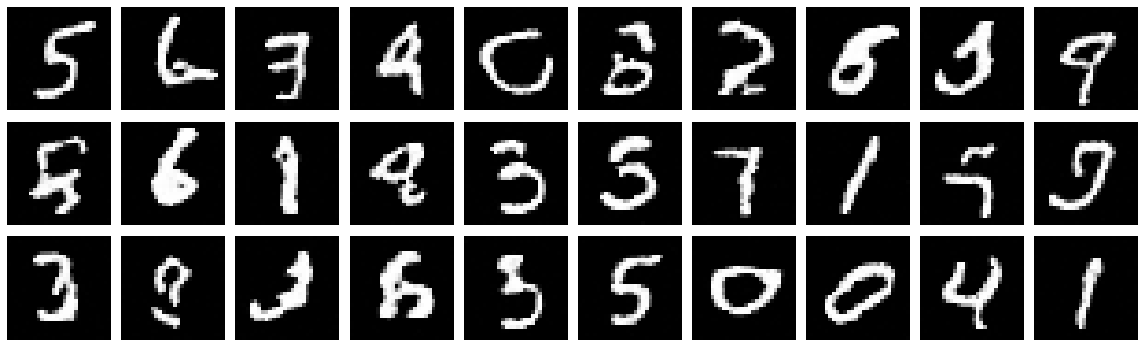

In [20]:
plot_samples('baseline_right', 'mnist')

## PCD

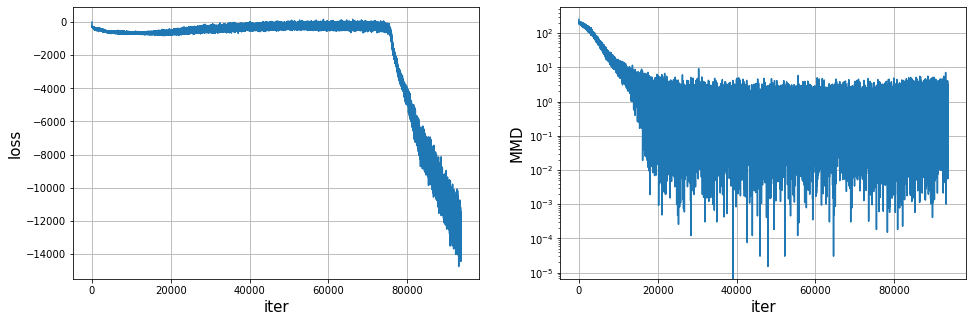

In [10]:
plot_training_process('pcd', 'mnist')

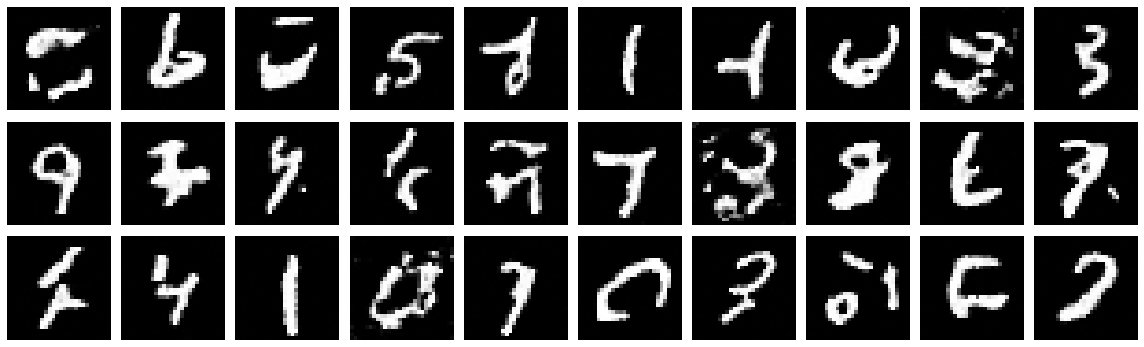

In [24]:
plot_samples('pcd', 'mnist')

## Beta

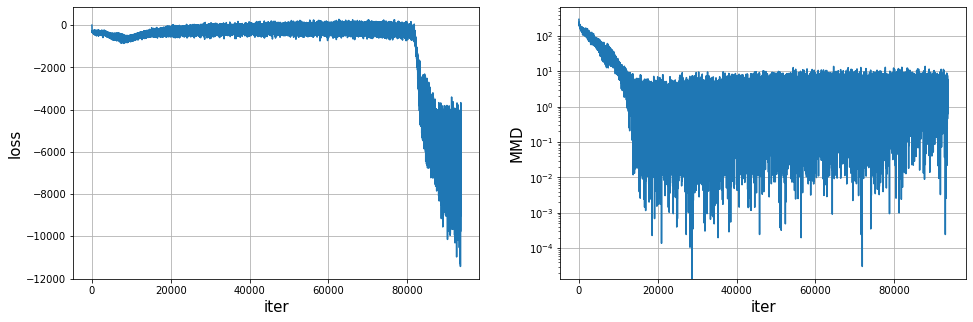

In [12]:
plot_training_process('beta_30steps', 'mnist')

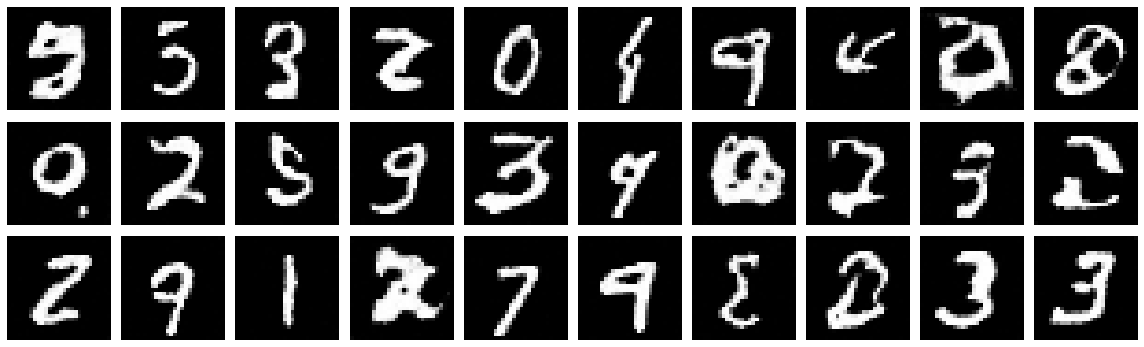

In [22]:
plot_samples('beta_30steps', 'mnist')

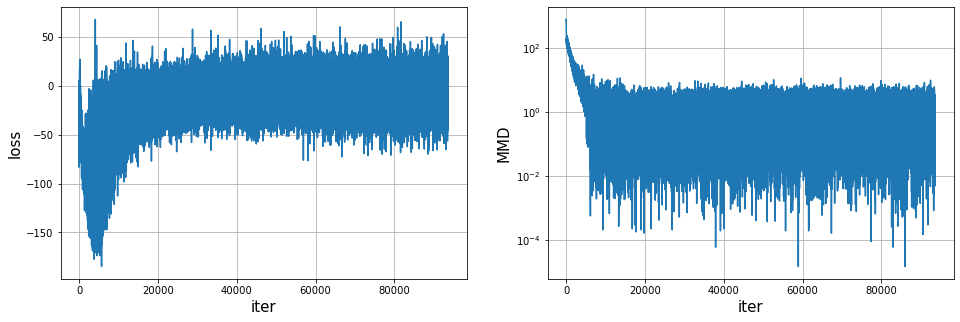

In [14]:
plot_training_process('beta_annealed', 'mnist')

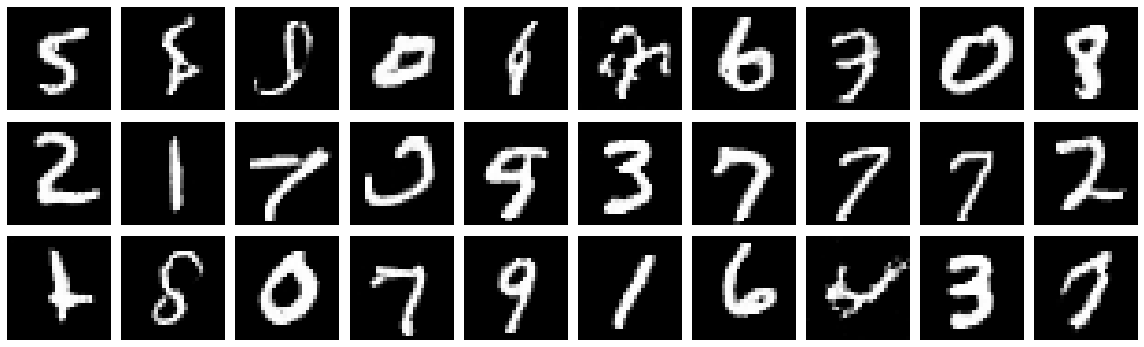

In [28]:
plot_samples('beta_annealed', 'mnist')

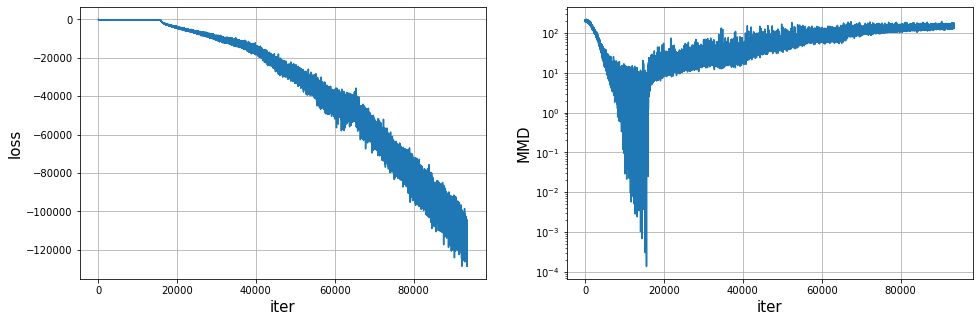

In [16]:
plot_training_process('beta', 'mnist')

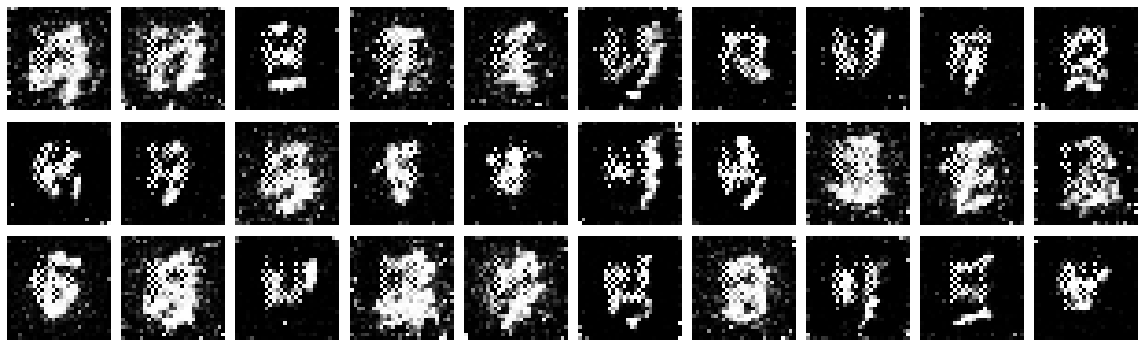

In [17]:
plot_samples('beta', 'mnist')

## Gamma

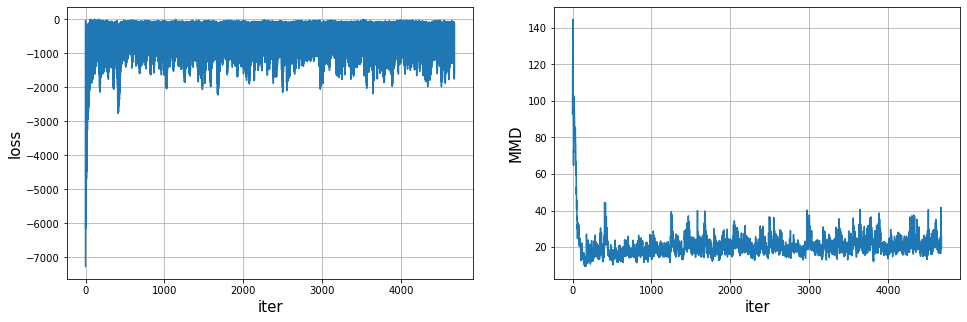

In [98]:
plot_training_process('gammaConv', 'mnist')

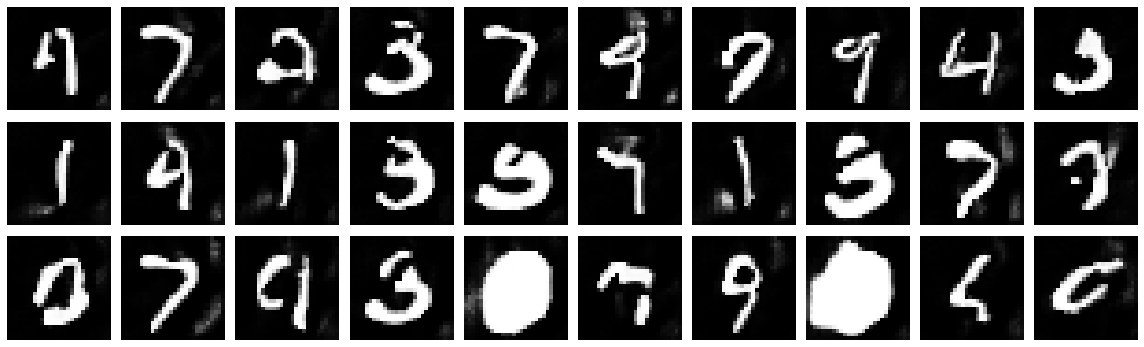

In [99]:
plot_samples('gammaConv', 'mnist')

In [17]:
label_ids = torch.tensor([0,4])
output = torch.arange(10).reshape(2,5)